In [1]:
from util.datagen import generator, tumor_generator
from util.model import build_seg_model
from cfg import *

import segmentation_models as sm
sm.set_framework('tf.keras')
import tensorflow.keras.backend as k
import gc
from albumentations import *
#from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

Segmentation Models: using `keras` framework.


In [2]:
import os, glob, datetime
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import tensorflow as tf
import IPython
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img, array_to_img
import PIL
from PIL import ImageOps
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['figure.figsize'] = (10,8)

In [3]:
import os, glob, datetime
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import tensorflow as tf
import IPython
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img, array_to_img
import PIL
from PIL import ImageOps
#os.environ["CUDA_VISIBLE_DEVICES"] = '0'

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
    # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
        print(e)
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['figure.figsize'] = (10,8)

2 Physical GPUs, 2 Logical GPUs


In [4]:
CLASS_NAME='nerve'
if CLASS_NAME=='nerve':
    TRUE_LABEL_LIST = [
        {'label':2,'restrict':0},
        {'label':3,'restrict':0}
    ]
    ZERO_LABEL_LIST = [
        {'label':1,'restrict':5},
        {'label':4,'restrict':10}
    ]
elif CLASS_NAME=='tumor':
    TRUE_LABEL_LIST = [
    {'label':1,'restrict':0}
    ]
    ZERO_LABEL_LIST = [
        {'label':2,'restrict':100},
        {'label':3,'restrict':100},
        {'label':4,'restrict':100}
    ]
else:
    TRUE_LABEL_LIST = [
        {'label':1,'restrict':100},
        {'label':2,'restrict':100},
        {'label':3,'restrict':100},
        {'label':4,'restrict':100}
    ]
    ZERO_LABEL_LIST = [] 

In [5]:
ALL_SLIDE_PATHS = []; [ALL_SLIDE_PATHS.extend(glob.glob(path+'*.tiff')) for path in ALL_PATIENT_PATHS]
TRAIN_SLIDE_PATHS = shuffle(ALL_SLIDE_PATHS,random_state=311)[:int(DATA_SPLIT[0]*len(ALL_SLIDE_PATHS))]
VALID_SLIDE_PATHS = shuffle(ALL_SLIDE_PATHS,random_state=311)[int(DATA_SPLIT[0]*len(ALL_SLIDE_PATHS)):-int(DATA_SPLIT[2]*len(ALL_SLIDE_PATHS))]
TEST_SLIDE_PATHS = shuffle(ALL_SLIDE_PATHS,random_state=311)[-int(DATA_SPLIT[2]*len(ALL_SLIDE_PATHS)):]

TEST_ZIP = []
for path in TEST_SLIDE_PATHS:
    slide_name = path.split('/')[-1].replace('.tiff','').replace('.svs','')
    patient_path = '/'.join(path.split('/')[:-1]) + '/'
    
    for lbl in TRUE_LABEL_LIST :
        target_list = glob.glob(patient_path+f'{PATCH_NAME}/mask/{slide_name}*_p{lbl["label"]}.png')
        TEST_ZIP.extend(target_list) 
    
    for lbl in ZERO_LABEL_LIST :
        target_list = glob.glob(patient_path+f'{PATCH_NAME}/mask/{slide_name}*_p{lbl["label"]}.png')
        TEST_ZIP.extend(shuffle(target_list,random_state = 311)[:lbl["restrict"]])
        
TEST_ZIP = shuffle([('/'.join(x.split('/')[:-2])+'/image/'+re.sub('_p[0-9]','',x.split('/')[-1]),x) for x in TEST_ZIP],random_state=311)

ZERO_LABELS = [x['label'] for x in ZERO_LABEL_LIST]


In [6]:
te_1 = 0; te_2 = 0; te_3 = 0 ; te_4 = 0

for tup in TEST_ZIP:
    x = tup[-1][-5]
    if x=='1':
        te_1+=1
    elif x=='2':
        te_2+=1
    elif x=='3':
        te_3+=1
    else:
        te_4+=1
print(f'TEST PATCH CLASS\nTUMOR : {te_1 } NERVE : {te_2+te_3} NORMAL : {te_4}')

TEST PATCH CLASS
TUMOR : 70 NERVE : 57 NORMAL : 0


In [7]:
if CLASS_NAME=='multi':
    binary=False
else:
    binary=True
test_set = generator(zip_path_list=TEST_ZIP,batch_size=BATCH_SIZE,zero_labels = ZERO_LABELS,is_train=False,binary=binary)

In [8]:
from sklearn.utils import compute_class_weight

In [9]:
it = iter(test_set)
backs = 0; tumors =0; nerves = 0
for i in range(50):
    try:
        batch_x,batch_y = next(it)
        backs += np.sum(batch_y[...,0])
        tumors+= np.sum(batch_y[...,1])
        nerves+= np.sum(batch_y[...,2])
    except:
        pass
print(backs,tumors,nerves)

1988.0 1988.0 2078.0


In [13]:
labels = [0]*int(backs) + [1]* int(tumors) + [2]* int(nerves)
labels

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [16]:
cw = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y = labels
)
print(cw)
print(np.log1p(cw))

[ 0.48073322  1.21067818 10.65406763]
[0.39253739 0.79329934 2.45565527]


In [11]:
from util.model import *
import pandas as pd

In [10]:
it = iter(test_set)

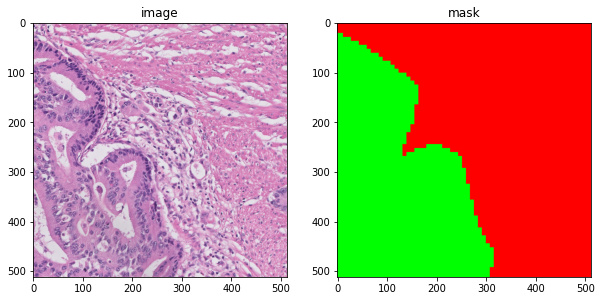

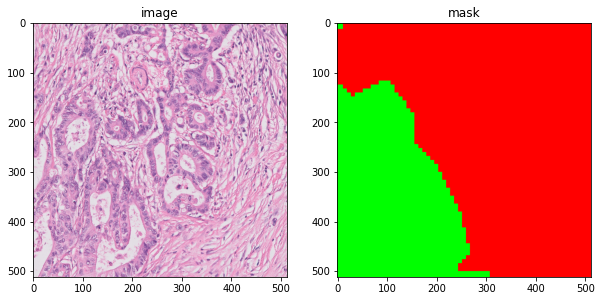

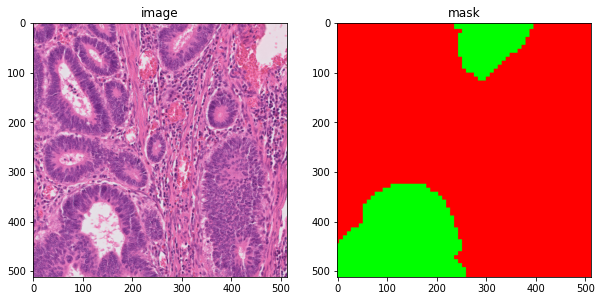

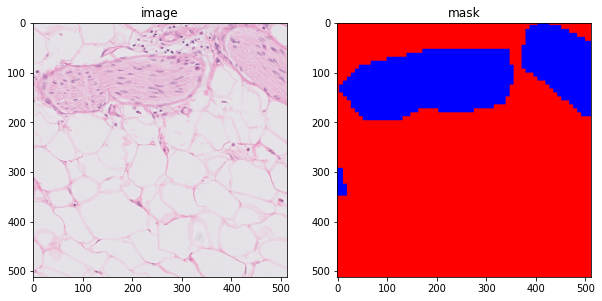

In [32]:
batch_x, batch_y = next(it)
for i in range(4):
    plt.figure()
    plt.subplot(1,2,1); plt.title('image'); plt.imshow(batch_x[i])
    plt.subplot(1,2,2); plt.title('mask'); plt.imshow(np.array(batch_y[i]).squeeze())

In [12]:
mdl_paths = glob.glob(f'./model/{CLASS_NAME}_{MAGNIFICATION}*10[1-2][0-9]*.hdf5')
#mdl_paths = glob.glob(f'./model/{CLASS_NAME}*')
mdls = [x.split('_')[2] for x in mdl_paths]
backbones = [x.split('_')[3] for x in mdl_paths]
weights = ['pascal_voc' if x=='xception' else 'imagenet' for x in backbones]
mdl_paths
#print(mdls, backbones, weights)

['./model/nerve_100_deeplab_xception_pascal_voc_1018_ce.hdf5',
 './model/nerve_100_unet_efficientnetb0_imagenet_1018_ce.hdf5',
 './model/nerve_100_deeplab_xception_pascal_voc_1018_focal.hdf5',
 './model/nerve_100_unet_efficientnetb0_imagenet_1018_focal.hdf5',
 './model/nerve_100_unet_efficientnetb0_imagenet_1019_ce.hdf5',
 './model/nerve_100_unet_efficientnetb0_imagenet_1019_focal.hdf5',
 './model/nerve_100_unet_efficientnetb0_imagenet_1027_focal.hdf5',
 './model/nerve_100_unet_efficientnetb0_imagenet_1027_ce.hdf5',
 './model/nerve_100_deeplab_xception_pascal_voc_1027_focal.hdf5',
 './model/nerve_100_deeplab_xception_pascal_voc_1027_ce.hdf5']

In [13]:
if CLASS_NAME=='multi':
    dice_loss = sm.losses.DiceLoss(per_image=True,smooth=1e+0,class_weights=np.array([0.4,0.75,2.5]))
    focal_loss = sm.losses.CategoricalFocalLoss(alpha = 0.25, gamma = 6.0)
else:
    dice_loss = sm.losses.DiceLoss()
    focal_loss = sm.losses.BinaryFocalLoss(alpha=0.25, gamma=6.0)
loss = dice_loss + focal_loss

optim = Adam(INITIAL_LEARNING_RATE)
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5),sm.metrics.Recall(),sm.metrics.Precision()]

In [14]:
test_df = pd.DataFrame(columns = ['model','backbone','loss','iou','fscore','recall','precision'])

In [15]:
i = 0
if CLASS_NAME=='multi':
    activation='softmax'; n_classes = 3
else:
    activation='sigmoid'; n_classes = 1
for idx in range(len(mdl_paths)):
    try:
        mdl_path = mdl_paths[idx]; 
        mdl_st = mdls[idx]
        backbone = backbones[idx]; 
        weight = weights[idx]
        append_row = [mdl_st,backbone]
        print(mdl_st,backbone,weight,activation,n_classes)
        mdl = build_seg_model(
            model = mdl_st,
            backbone=backbone,
            weight=weight,
            activation=activation,
            n_classes = n_classes
        )
        mdl.load_weights(mdl_path)
        mdl.compile(optim,loss,metrics)
        print(f'MODEL : {mdl_path}')
        eval_res = mdl.evaluate(test_set)
        append_row.extend(eval_res)
        test_df.loc[i,:] = append_row
        i+=1
    except Exception as e:
        print(e)
        continue
    if (idx+1)%5==0:
        print(f'{idx+1} Doing')

deeplab xception pascal_voc sigmoid 1
MODEL : ./model/nerve_100_deeplab_xception_pascal_voc_1018_ce.hdf5
3/3 [==============================] - 11s 493ms/step - loss: 0.1912 - iou_score: 0.7514 - f1-score: 0.8580 - recall: 0.9176 - precision: 0.7734
unet efficientnetb0 imagenet sigmoid 1
MODEL : ./model/nerve_100_unet_efficientnetb0_imagenet_1018_ce.hdf5
3/3 [==============================] - 6s 204ms/step - loss: 0.1762 - iou_score: 0.7746 - f1-score: 0.8728 - recall: 0.8991 - precision: 0.8143
deeplab xception pascal_voc sigmoid 1
MODEL : ./model/nerve_100_deeplab_xception_pascal_voc_1018_focal.hdf5
3/3 [==============================] - 7s 487ms/step - loss: 0.3439 - iou_score: 0.6093 - f1-score: 0.7572 - recall: 0.9300 - precision: 0.5714
unet efficientnetb0 imagenet sigmoid 1
MODEL : ./model/nerve_100_unet_efficientnetb0_imagenet_1018_focal.hdf5
3/3 [==============================] - 5s 205ms/step - loss: 0.1541 - iou_score: 0.7983 - f1-score: 0.8877 - recall: 0.9448 - precision: 

In [16]:
test_df

,model,backbone,loss,iou,fscore,recall,precision
0,deeplab,xception,0.191192,0.751427,0.857995,0.917563,0.773408
1,unet,efficientnetb0,0.176162,0.774576,0.872797,0.899108,0.814292
2,deeplab,xception,0.343942,0.609308,0.757162,0.929984,0.571353
3,unet,efficientnetb0,0.154084,0.798255,0.887676,0.94476,0.819482
4,unet,efficientnetb0,0.346765,0.777941,0.875011,0.962077,0.802501
5,unet,efficientnetb0,0.336698,0.7845,0.87881,0.966328,0.80626
6,deeplab,xception,0.373344,0.731876,0.845164,0.91027,0.788704
7,deeplab,xception,0.294411,0.771974,0.871223,0.908326,0.837453


---

In [18]:
idx = 3
mdl = build_seg_model(
            model = mdls[idx],
            backbone=backbones[idx],
            weight=weights[idx],
            activation='softmax',
            n_classes = 3
        )
mdl.load_weights(mdl_paths[idx])
idx = 5
mdl2 = build_seg_model(
            model = mdls[idx],
            backbone=backbones[idx],
            weight=weights[idx],
            activation='softmax',
            n_classes = 3
        )
mdl2.load_weights(mdl_paths[idx])

ValueError: Cannot assign to variable final_conv/kernel:0 due to variable shape (3, 3, 16, 3) and value shape (1, 16, 3, 3) are incompatible

In [18]:
it = iter(test_set)

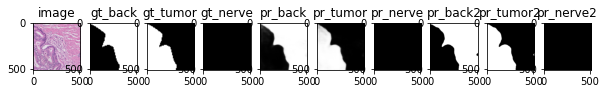

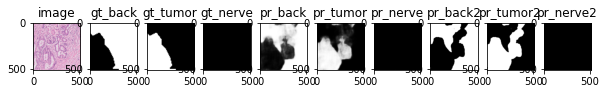

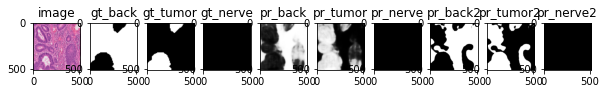

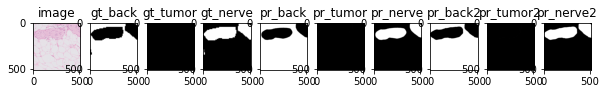

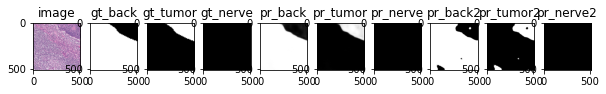

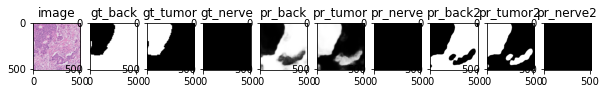

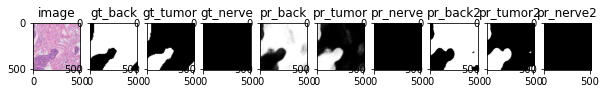

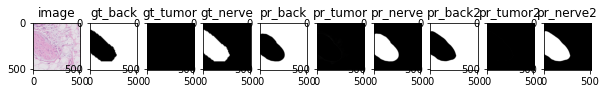

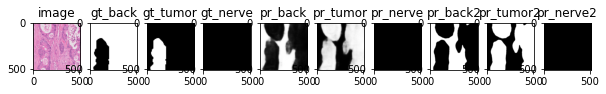

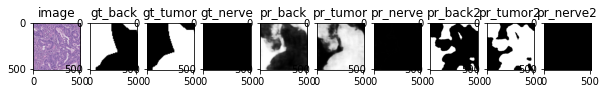

In [19]:
batch_x, batch_y = next(it)
for i in range(10):
    plt.figure()
    model_input = np.expand_dims(batch_x[i],0)
    plt.subplot(1,10,1); plt.title('image'); plt.imshow(np.array(batch_x[i]))
    plt.subplot(1,10,2); plt.title('gt_back'); plt.imshow(np.array(batch_y[i][...,0]),vmin=0,vmax=1)
    plt.subplot(1,10,3); plt.title('gt_tumor'); plt.imshow(np.array(batch_y[i][...,1]),vmin=0,vmax=1)
    plt.subplot(1,10,4); plt.title('gt_nerve'); plt.imshow(np.array(batch_y[i][...,2]),vmin=0,vmax=1)
    pred_prob = mdl.predict(model_input)
    pred_prob_back = pred_prob[...,0]
    pred_prob_tumor = pred_prob[...,1]
    pred_prob_nerve = pred_prob[...,2]
    
    pred_prob2 = mdl2.predict(model_input)
    pred_prob_back2 = pred_prob2[...,0]
    pred_prob_tumor2 = pred_prob2[...,1]
    pred_prob_nerve2 = pred_prob2[...,2]
    
    
    #plt.subplot(1,10,5); plt.title('pr_prob'); plt.imshow((pred_prob).squeeze())
    plt.subplot(1,10,5); plt.title('pr_back'); plt.imshow(pred_prob_back.squeeze())
    plt.subplot(1,10,6); plt.title('pr_tumor'); plt.imshow(pred_prob_tumor.squeeze())
    plt.subplot(1,10,7); plt.title('pr_nerve'); plt.imshow(pred_prob_nerve.squeeze())
    
    #plt.subplot(1,10,5); plt.title('pr_prob2'); plt.imshow((pred_prob2).squeeze())
    plt.subplot(1,10,8); plt.title('pr_back2'); plt.imshow(pred_prob_back2.squeeze())
    plt.subplot(1,10,9); plt.title('pr_tumor2'); plt.imshow(pred_prob_tumor2.squeeze())
    plt.subplot(1,10,10); plt.title('pr_nerve2'); plt.imshow(pred_prob_nerve2.squeeze())

---

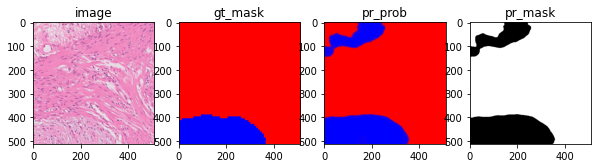

In [58]:
batch_x , batch_y = next(it)
for i in range(1):
    plt.figure()
    model_input = np.expand_dims(batch_x[i],0)
    pred_prob = mdl.predict(model_input)
    pred_mask = np.where(pred_prob>0.5,1,0)
    plt.subplot(1,4,1); plt.title('image'); plt.imshow(np.array(batch_x[i]))
    plt.subplot(1,4,2); plt.title('gt_mask'); plt.imshow(np.array(batch_y[i]))
    plt.subplot(1,4,3); plt.title('pr_prob'); plt.imshow(np.array(pred_prob).squeeze())
    plt.subplot(1,4,4); plt.title('pr_mask_nerve'); plt.imshow(np.array(pred_mask[...,0]).squeeze())
    plt.subplot(1,4,4); plt.title('pr_mask_tumor'); plt.imshow(np.array(pred_mask[...,1]).squeeze())
    plt.subplot(1,4,4); plt.title('pr_mask_tumor'); plt.imshow(np.array(pred_mask[...,2]).squeeze())
    
    

In [27]:
np.array([[0,0,0],[0,0,0],[0,0,0]]).shape

(3, 3)

In [31]:
import tensorflow.keras.backend as K


In [38]:
tf.constant(np.array([1,2,3]))

<tf.Tensor: shape=(3,), dtype=int64, numpy=array([1, 2, 3])>

In [33]:
K.sum([[1,2,3,4,5]])

<tf.Tensor: shape=(), dtype=int32, numpy=15>

In [162]:
dice_loss = sm.losses.DiceLoss(per_image=True,smooth = 1e-5,)

In [147]:
focal_loss = sm.losses.BinaryFocalLoss()

In [141]:
tst_msk2[:128][:][:] =1.0

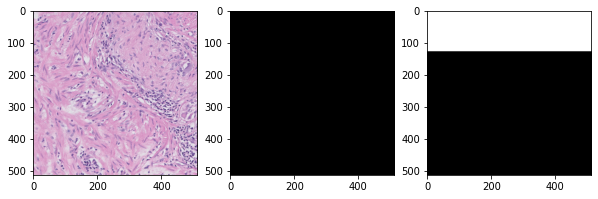

In [186]:
plt.figure();
plt.subplot(1,3,1); plt.imshow(tst)
plt.subplot(1,3,2); plt.imshow(tst_msk)
plt.subplot(1,3,3); plt.imshow(tst_msk2)

In [194]:
smth = 1e+2
dice_loss = sm.losses.DiceLoss(per_image=True,smooth = smth,class_weights = np.array([1]))
focal_loss = sm.losses.BinaryFocalLoss()
cat_loss = sm.losses.BinaryCELoss()
print(
    dice_loss(np.reshape(tst_gt,(-1,512,512)),np.reshape(tst_pr,(-1,512,512))),'\n',
    focal_loss(np.reshape(tst_gt,(-1,512,512)),np.reshape(tst_pr,(-1,512,512))),'\n',
    cat_loss(np.reshape(tst_gt,(-1,512,512)),np.reshape(tst_pr,(-1,512,512))),'\n',
    '-- gt is not blank pr is blank --\n',
    dice_loss(np.reshape(tst_gt,(-1,512,512)),np.reshape(tst_msk,(-1,512,512))),'\n',
    focal_loss(np.reshape(tst_gt,(-1,512,512)),np.reshape(tst_msk,(-1,512,512))),'\n',
    cat_loss(np.reshape(tst_gt,(-1,512,512)),np.reshape(tst_msk,(-1,512,512))),'\n',
    '-- gt is blank pr is not blank --\n',
    dice_loss(np.reshape(tst_msk,(-1,512,512)),np.reshape(tst_gt,(-1,512,512))),'\n',
    focal_loss(np.reshape(tst_msk,(-1,512,512)),np.reshape(tst_gt,(-1,512,512))),'\n',
    cat_loss(np.reshape(tst_msk,(-1,512,512)),np.reshape(tst_gt,(-1,512,512))),'\n',
    
)

tf.Tensor(0.07541692, shape=(), dtype=float32) 
 tf.Tensor(0.029652752, shape=(), dtype=float32) 
 tf.Tensor(0.08191393, shape=(), dtype=float32) 
 -- gt is not blank pr is blank --
 tf.Tensor(0.9982859, shape=(), dtype=float32) 
 tf.Tensor(0.89523077, shape=(), dtype=float32) 
 tf.Tensor(3.4269288, shape=(), dtype=float32) 
 -- gt is blank pr is not blank --
 tf.Tensor(0.9982859, shape=(), dtype=float32) 
 tf.Tensor(2.6564147, shape=(), dtype=float32) 
 tf.Tensor(3.4065542, shape=(), dtype=float32) 



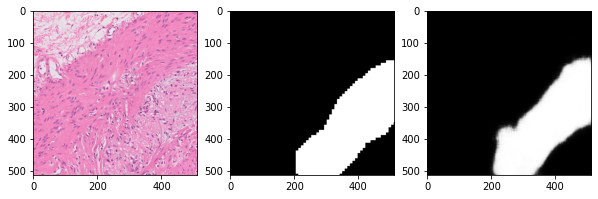

In [169]:
tst_img = img_batch[-1]
tst_gt = msk_batch[-1]
tst_pr = pred_prob
plt.figure(); 
plt.subplot(1,3,1); plt.imshow(tst_img); 
plt.subplot(1,3,2); plt.imshow(tst_gt); 
plt.subplot(1,3,3); plt.imshow(tst_pr); 

In [163]:
print(
    dice_loss(tst_msk2,tst_msk),'\n',
    dice_loss(tst_msk,tst_msk2),'\n',
    focal_loss(tst_msk,tst_msk2),'\n',
    focal_loss(tst_msk2,tst_msk)
)


tf.Tensor(0.25, shape=(), dtype=float32) 
 tf.Tensor(0.25, shape=(), dtype=float32) 
 tf.Tensor(2.9891965, shape=(), dtype=float32) 
 tf.Tensor(1.0073806, shape=(), dtype=float32)


In [62]:
tst = np.array(batch_x[0])

In [63]:
tst.shape

(512, 512, 3)

In [111]:
tst_msk = np.zeros_like(tst)
tst_msk2 = tst_msk.copy()

In [60]:
loss(
    tf.constant(np.reshape(np.array([[0,1,1],[1,1,0],[0,0,0]],dtype=np.float32),(-1,512,512,3))),
    tf.constant(np.reshape(np.array([[0,0,0],[0,0,0],[0,0,0]],dtype=np.float32),(-1,3,3,1))),
)

<tf.Tensor: shape=(), dtype=float32, numpy=0.28571427>

In [48]:
sm.losses.dice_loss(
    tf.constant(np.reshape(np.array([[0,1,1],[1,1,0],[0,0,0]],dtype=np.float32),(-1,3,3,1))),
    tf.constant(np.reshape(np.array([[0,0,0],[0,0,0],[0,0,0]],dtype=np.float32),(-1,3,3,1))),
)

<tf.Tensor: shape=(), dtype=float32, numpy=0.9999975>

In [23]:
t = pred_prob.squeeze()

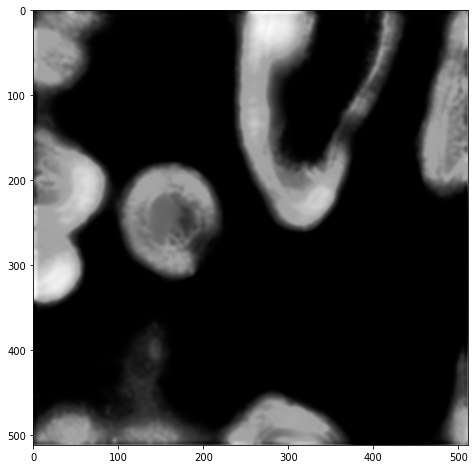

In [34]:
plt.imshow((t*255).astype(np.uint8))

In [78]:
(t_thr/255).dtype

dtype('float64')

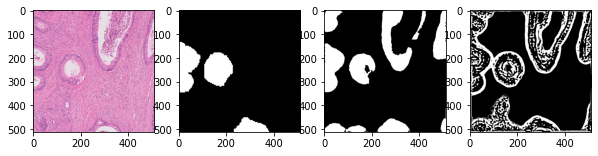

In [74]:
t_thr = cv.threshold((t*255).astype(np.uint8),127,255,cv.THRESH_BINARY|cv.THRESH_OTSU)[1]
t_adthr = cv.adaptiveThreshold((t*255).astype(np.uint8),255,cv.ADAPTIVE_THRESH_MEAN_C,cv.THRESH_BINARY_INV,11,1)
plt.subplot(1,4,1);plt.imshow(np.array(batch_x[0]).squeeze())
plt.subplot(1,4,2);plt.imshow(np.array(batch_y[0]).squeeze())
plt.subplot(1,4,3);plt.imshow(t_thr)
plt.subplot(1,4,4);plt.imshow(t_adthr)

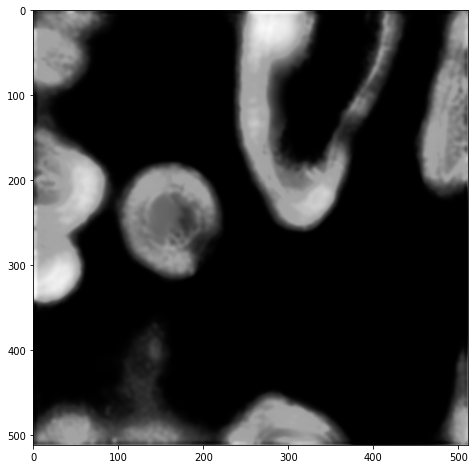

In [24]:
plt.imshow(t)

## BINARY

In [20]:
#mdl = build_seg_model('deeplab',)
#mdl.load_weights('./model/nerve_100_deeplab_xception_pascal_voc_0930dice_cross.hdf5')
idx = 3
mdl = build_seg_model(
    mdls[idx],
    backbone=backbones[idx],
    weight=weights[idx]
)

mdl.load_weights(mdl_paths[idx])
idx = -3
mdl2 = build_seg_model(
    mdls[idx],
    backbone=backbones[idx],
    weight=weights[idx]
)
mdl2.load_weights(mdl_paths[idx])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()


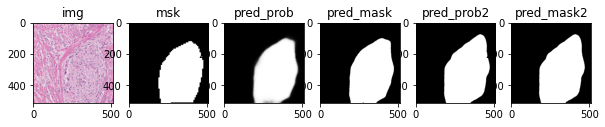

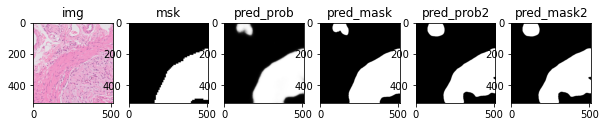

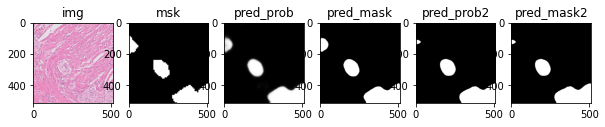

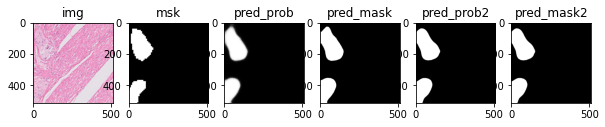

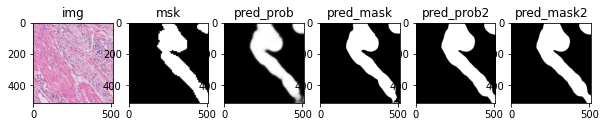

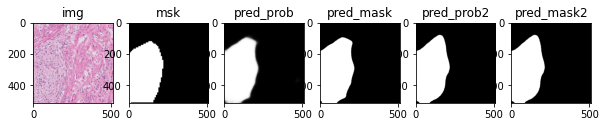

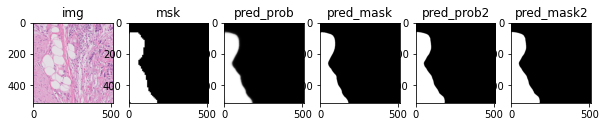

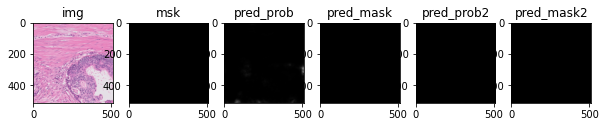

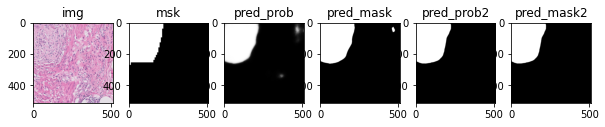

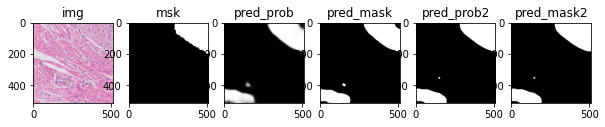

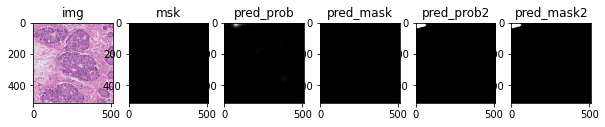

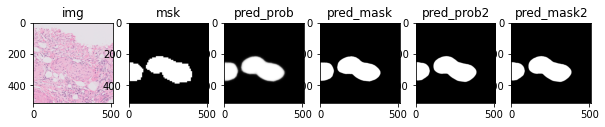

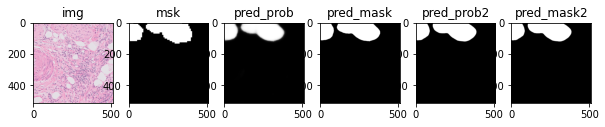

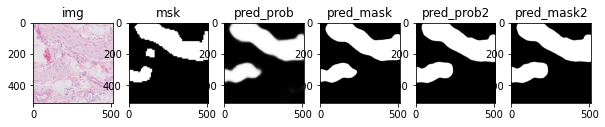

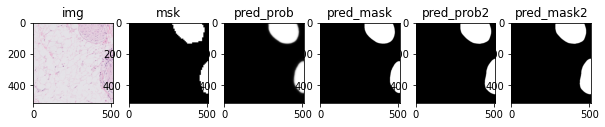

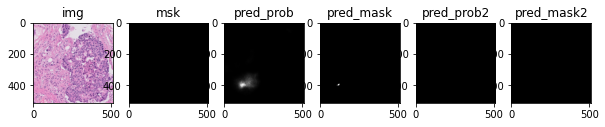

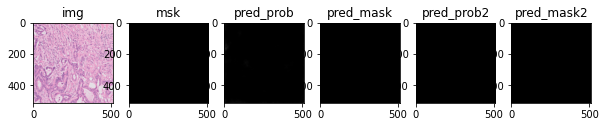

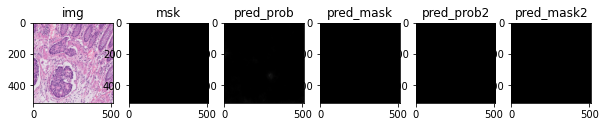

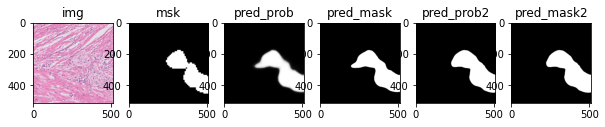

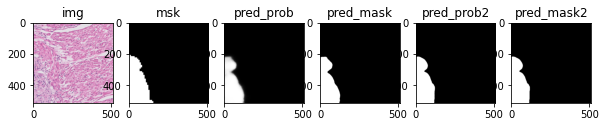

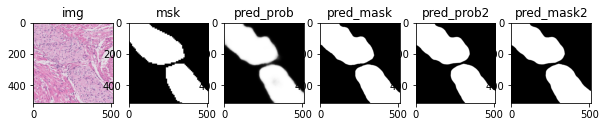

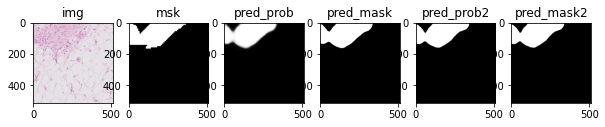

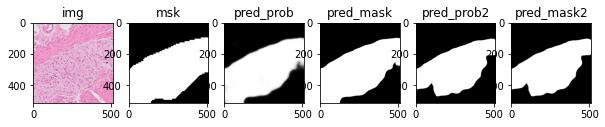

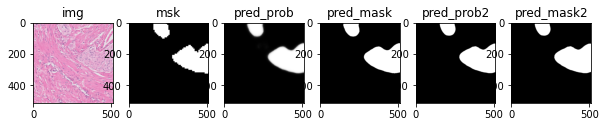

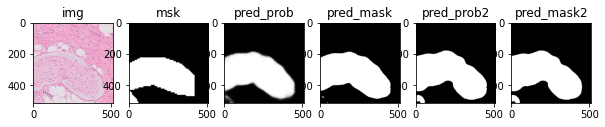

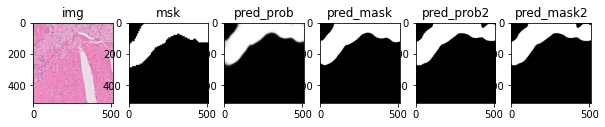

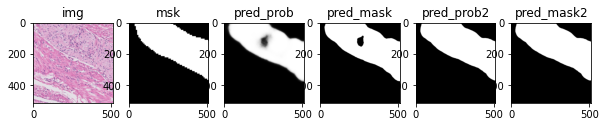

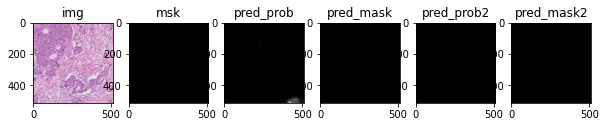

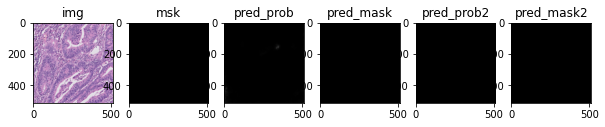

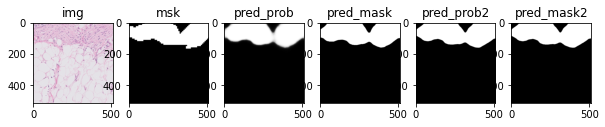

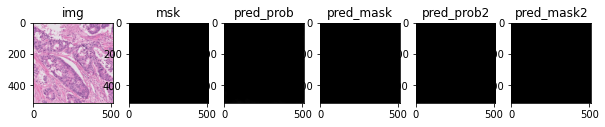

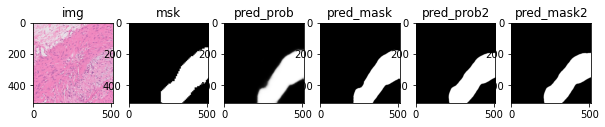

In [21]:
batch_set = test_set.take(1)
for img_batch,msk_batch in batch_set:
    for i in range(32):
        img_input = np.expand_dims(img_batch[i],axis =0)
        pred_prob = np.squeeze(mdl.predict(img_input))
        pred_mask = np.logical_and(pred_prob>0.5,1)
        
        pred_prob2 = np.squeeze(mdl2.predict(img_input))
        pred_mask2 = np.logical_and(pred_prob2>0.5,1)
        
        plt.figure()
        plt.subplot(1,6,1); plt.title('img') ; plt.imshow(img_batch[i])
        plt.subplot(1,6,2); plt.title('msk') ; plt.imshow(msk_batch[i])
        plt.subplot(1,6,3); plt.title('pred_prob') ; plt.imshow(pred_prob)
        plt.subplot(1,6,4); plt.title('pred_mask') ; plt.imshow(pred_mask)
        plt.subplot(1,6,5); plt.title('pred_prob2') ; plt.imshow(pred_prob2)
        plt.subplot(1,6,6); plt.title('pred_mask2') ; plt.imshow(pred_mask2)
        
        